# Regularization of linear regression model

In this notebook, we will see the limitations of linear regression models and
the advantage of using regularized models instead.

Besides, we will also present the preprocessing required when dealing
with regularized models, furthermore when the regularization parameter
needs to be tuned.

We will start by highlighting the over-fitting issue that can arise with
a simple linear regression model.

## Effect of regularization

We will first load the California housing dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In one of the previous notebook, we showed that linear models could be used
even in settings where `data` and `target` are not linearly linked.

We showed that one can use the `PolynomialFeatures` transformer to create
additional features encoding non-linear interactions between features.

Here, we will use this transformer to augment the feature space.
Subsequently, we will train a linear regression model. We will use the
out-of-sample test set to evaluate the generalization capabilities of our
model.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())
cv_results = cross_validate(linear_regression, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

We can compare the mean squared error on the training and testing set to
assess the generalization performance of our model.

In [3]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4190.212 +/- 151.123


In [4]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
13334.943 +/- 20292.681


The score on the training set is much better. This generalization performance
gap between the training and testing score is an indication that our model
overfitted our training set.

Indeed, this is one of the danger when augmenting the number of features
with a `PolynomialFeatures` transformer. Our model will focus on some
specific features. We can check the weights of the model to have a
confirmation. Let's create a dataframe: the columns will contain the name
of the feature while the line the coefficients values stored by each model
during the cross-validation.

Since we used a `PolynomialFeatures` to augment the data, we will create
feature names representative of the feature combination. Scikit-learn
provides a `get_feature_names_out` method for this purpose. First, let's get
the first fitted model from the cross-validation.

In [5]:
model_first_fold = cv_results["estimator"][0]

Now, we can access to the fitted `PolynomialFeatures` to generate the feature
names

In [6]:
feature_names = model_first_fold[0].get_feature_names_out(
    input_features=data.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

Finally, we can create the dataframe containing all the information.

In [7]:
import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)

Now, let's use a box plot to see the coefficients variations.

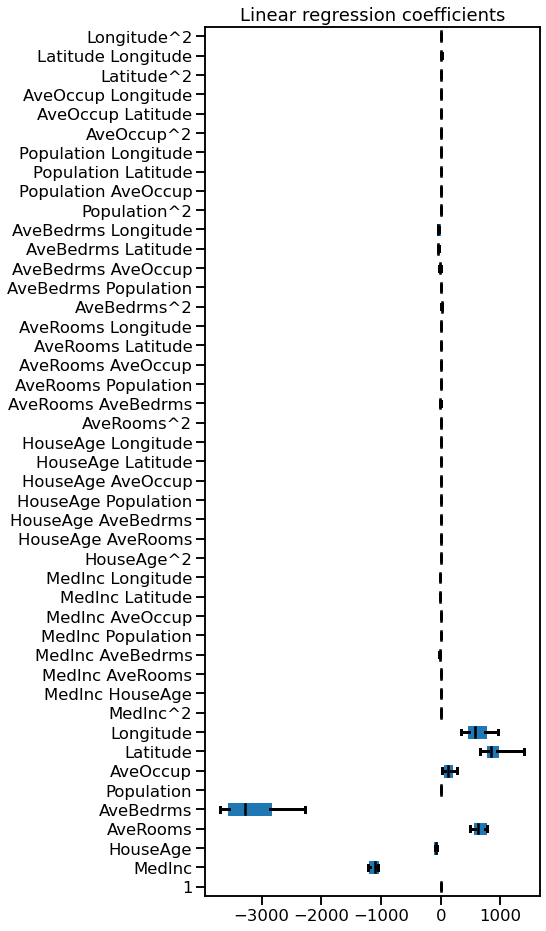

In [8]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Linear regression coefficients")

We can force the linear regression model to consider all features in a more
homogeneous manner. In fact, we could force large positive or negative weight
to shrink toward zero. This is known as regularization. We will use a ridge
model which enforces such behavior.

In [9]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(PolynomialFeatures(degree=2),
                      Ridge(alpha=100))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67257e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75536e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67367e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditio

The code cell above will generate a couple of warnings because the features
included both extremely large and extremely small values, which are causing
numerical problems when training the predictive model.

We can explore the train and test scores of this model.

In [10]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4373.180 +/- 153.942


In [11]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
7303.589 +/- 4950.732


We see that the training and testing scores are much closer, indicating that
our model is less overfitting. We can compare the values of the weights of
ridge with the un-regularized linear regression.

In [12]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

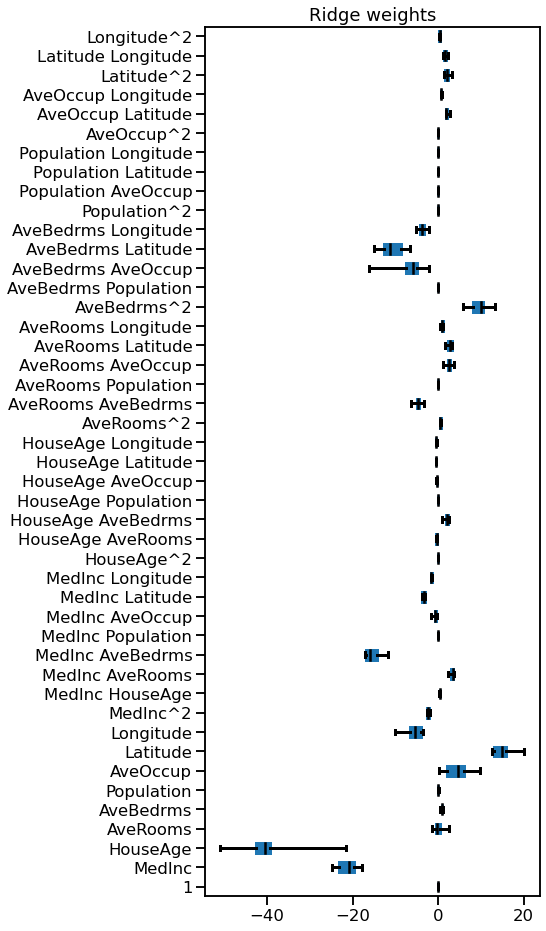

In [13]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights")

By comparing the magnitude of the weights on this plot compared to the
previous plot, we see that a ridge model will enforce all weights to have a
similar magnitude, while the overall magnitude of the weights is shrunk
towards zero with respect to the linear regression model.

However, in this example, we omitted two important aspects: (i) the need to
scale the data and (ii) the need to search for the best regularization
parameter.

## Feature scaling and regularization

On the one hand, weights define the link between feature values and the
predicted target.
On the other hand, regularization adds constraints on the weights of the
model through the `alpha` parameter. Therefore, the effect that feature
rescaling has on the final weights also interacts with regularization.

Let's consider the case where features live on the same scale/units: if
two features are found to be equally important by the model, they will be
affected similarly by regularization strength.

Now, let's consider the scenario where features have completely different
data scale (for instance age in years and annual revenue in dollars).
If two features are as important, our model will boost the weights of
features with small scale and reduce the weights of features with
high scale.

We recall that regularization forces weights to be closer. Therefore, we get
an intuition that if we want to use regularization, dealing with rescaled
data would make it easier to find an optimal regularization parameter and
thus an adequate model.

As a side note, some solvers based on gradient computation are expecting such
rescaled data. Unscaled data will be detrimental when computing the optimal
weights. Therefore, when working with a linear model and numerical data, it
is generally good practice to scale the data.

Thus, we will add a `StandardScaler` in the machine learning pipeline. This
scaler will be placed just before the regressor.

In [14]:
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=0.5))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [15]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4347.036 +/- 156.666


In [16]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
5508.472 +/- 1816.642


We observe that scaling data has a positive impact on the test score and that
the test score is closer to the train score. It means that our model is less
overfitted and that we are getting closer to the best generalization sweet
spot.

Let's have an additional look to the different weights.

In [17]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

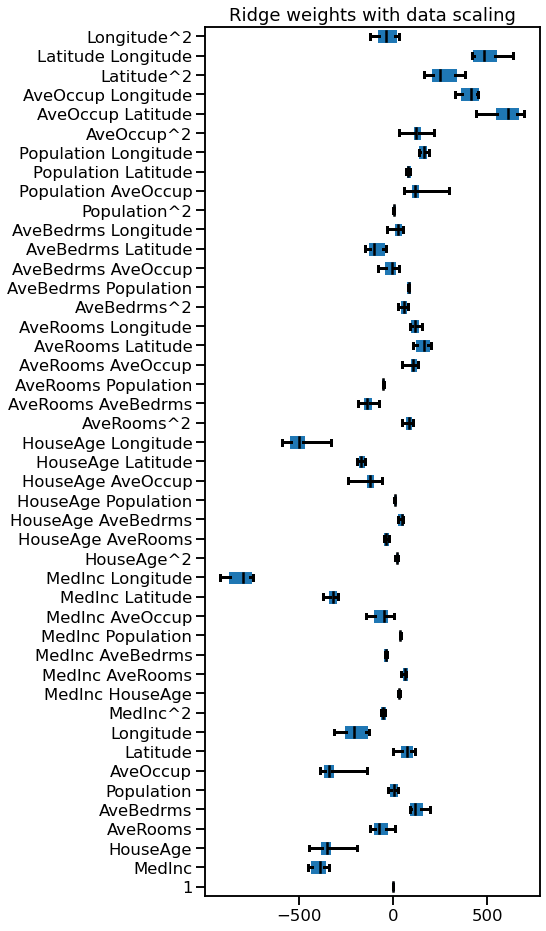

In [18]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

Compare to the previous plots, we see that now all weight magnitudes are
closer and that all features are more equally contributing.

In the previous example, we fixed `alpha=0.5`. We will now check the impact
of the value of `alpha` by increasing its value.

In [19]:
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=1_000_000))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [20]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

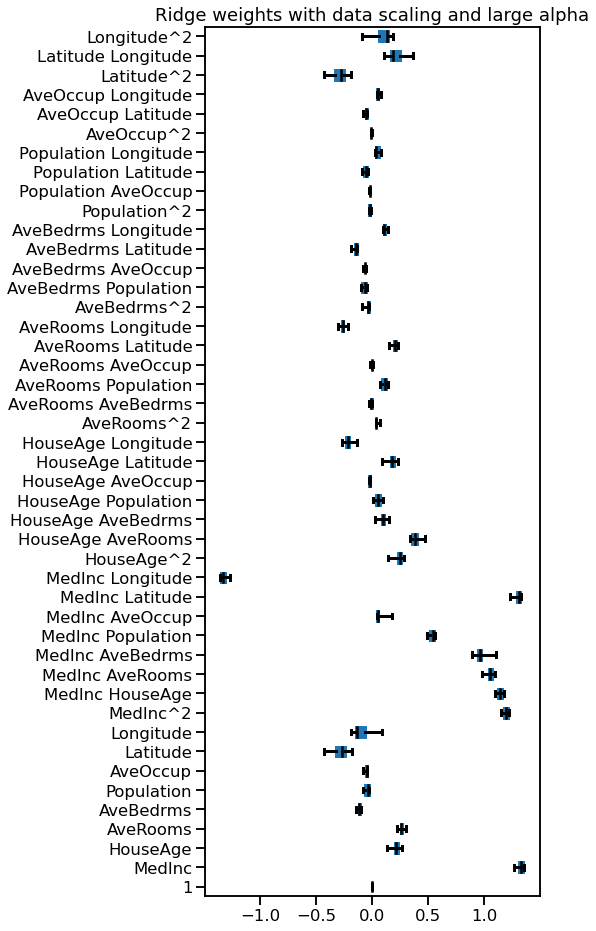

In [21]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling and large alpha")

Looking specifically to weights values, we observe that increasing the value
of `alpha` will decrease the weight values. A negative value of `alpha` would
actually enhance large weights and promote overfitting.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>Here, we only focus on numerical features. For categorical features, it is
generally common to omit scaling when features are encoded with a
<tt class="docutils literal">OneHotEncoder</tt> since the feature values are already on a similar scale.</p>
<p class="last">However, this choice can be questioned since scaling interacts with
regularization as well. For instance, scaling categorical features that are
imbalanced (e.g. more occurrences of a specific category) would even out
the impact of regularization to each category. However, scaling such features
in the presence of rare categories could be problematic (i.e. division by a very
small standard deviation) and it can therefore introduce numerical issues.</p>
</div>

In the previous analysis, we did not study if the parameter `alpha` will have
an effect on the performance. We chose the parameter beforehand and fix it
for the analysis.

In the next section, we will check the impact of the regularization
parameter `alpha` and how it should be tuned.

## Fine tuning the regularization parameter

As mentioned, the regularization parameter needs to be tuned on each dataset.
The default parameter will not lead to the optimal model. Therefore, we need
to tune the `alpha` parameter.

Model hyperparameter tuning should be done with care. Indeed, we want to
find an optimal parameter that maximizes some metrics. Thus, it requires both
a training set and testing set.

However, this testing set should be different from the out-of-sample testing
set that we used to evaluate our model: if we use the same one, we are using
an `alpha` which was optimized for this testing set and it breaks the
out-of-sample rule.

Therefore, we should include search of the hyperparameter `alpha` within the
cross-validation. As we saw in previous notebooks, we could use a
grid-search. However, some predictor in scikit-learn are available with
an integrated hyperparameter search, more efficient than using a grid-search.
The name of these predictors finishes by `CV`. In the case of `Ridge`,
scikit-learn provides a `RidgeCV` regressor.

Therefore, we can use this predictor as the last step of the pipeline.
Including the pipeline a cross-validation allows to make a nested
cross-validation: the inner cross-validation will search for the best
alpha, while the outer cross-validation will give an estimate of the
testing score.

In [22]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [23]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

In [24]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4306.562 +/- 25.918


In [25]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
4348.657 +/- 252.921


By optimizing `alpha`, we see that the training and testing scores are close.
It indicates that our model is not overfitting.

When fitting the ridge regressor, we also requested to store the error found
during cross-validation (by setting the parameter `store_cv_values=True`).
We will plot the mean squared error for the different `alphas` regularization
strength that we tried.

In [26]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,7587.897141,7059.531216,6579.796667,6161.839629,5813.048345,5535.350138,5326.646369,5182.950517,5100.749049,5079.212663,5122.029454,5238.704149,5445.118890,5763.012259,6217.925433,6835.274126,7634.692137,8623.620241,9791.918443,11109.476019
1,7079.341771,6696.622046,6329.022308,5987.727181,5681.306000,5415.171818,5191.880969,5012.209177,4876.780585,4787.974274,4751.851652,4779.853646,4889.937328,5106.656625,5459.549144,5979.280717,6691.530974,7609.581815,8727.609953,10017.092899
2,24857.406605,21448.284772,18293.478416,15481.009011,13067.031991,11071.457116,9480.437579,8254.431555,7338.963939,6675.026438,6207.024331,5887.541169,5679.263698,5554.913823,5496.051755,5491.367683,5534.775517,5623.398006,5755.456140,5928.154410
3,7504.216958,7125.074257,6754.172985,6400.999897,6072.937966,5774.941819,5509.955509,5280.027720,5087.960263,4939.271829,4844.228092,4819.618117,4889.808854,5086.420585,5445.877349,6004.320850,6790.113763,7815.311733,9068.542918,10511.939341
4,6999.938808,6598.898742,6215.363499,5861.328579,5546.025773,5275.377052,5052.349007,4878.140850,4753.964890,4683.117084,4673.049960,4737.162496,4895.935124,5176.863333,5612.500529,6236.037942,7074.449338,8140.303978,9424.471281,10892.352852


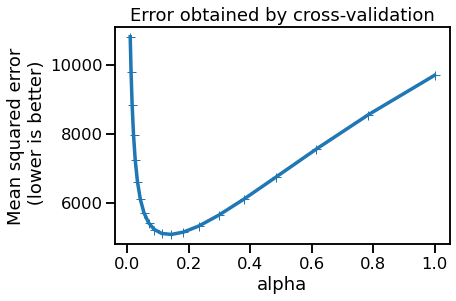

In [27]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

As we can see, regularization is just like salt in cooking: one must balance
its amount to get the best generalization performance. We can check if the best
`alpha` found is stable across the cross-validation fold.

In [28]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]

The optimal regularization strength is not necessarily the same on all
cross-validation iterations. But since we expect each cross-validation
resampling to stem from the same data distribution, it is common practice
to use the average value of the best `alpha` found on different
cross-validation folds as our final estimate for the tuned `alpha`.

In [ ]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
      f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")


In this notebook, you learned about the concept of regularization and
the importance of preprocessing and parameter tuning.